# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture

import thinkplot

## The rain in Boston problem

According to hydrologists, the distribution of total daily
  rainfall (for days with rain) is well modeled by a two-parameter
  gamma distribution.  There are several ways to parameterize the
  gamma distribution; we'll use the one with a shape parameter, $k$, and
  a scale parameter, $\theta$, described by this PDF:

$ \mathrm{pdf}(x; k, \theta) = \frac{1}{\Gamma(k)\theta^k} x^{k-1} \exp(-x/\theta) $

where $\Gamma$ is the gamma function.

1. Evaluate this PDF for $x=2$, $k=3$, and $\theta=2$ using NumPy functions and `scipy.special.gamma`.

2. Evaluate this PDF using `scipy.stats.gamma`, and confirm that you get the same answer.

3. During the last three days in the Boston area, we have measured the following rainfalls in inches: 0.78, 0.87, 0.64.

Use this data to compute a joint posterior distributions for the
parameters of the gamma distribution.  

You can use the following priors:

* For $k$, Half-normal with $\sigma = 0.5$.

* For $\theta$, Half-normal with $\sigma = 4$.


4. What are the posterior means for $k$ and $\theta$?

5. Generate a predictive distribution for the amount of rain we will get tomorrow (assuming that it rains at all).  What is the predictive mean?


### Solution

First, here's a function to evaluate the gamma PDF.

In [2]:
from scipy.special import gamma

def gamma_pdf(x, k, theta):
    return x**(k-1) * np.exp(-x/theta) / gamma(k) / theta**k

And here's a version using `scipy.stats`, translating from the $k$, $\theta$ parameterization to SciPy's inhumane parameterization.

In [3]:
from scipy import stats

def gamma_pdf2(x, k, theta):
    return stats.gamma(k, scale=theta).pdf(x)

Evaluting the PDF at a test location...

In [4]:
x = 2
k = 3
theta = 2 

gamma_pdf(x, k, theta)

0.09196986029286058

And comparing to the results from SciPy

In [5]:
gamma_pdf2(x, k, theta)

0.09196986029286057

Now here's the `Suite` we'll use to estimate parameters from data.

In [6]:
class Rainfall(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: observed rainfall
        hypo: k, theta
        """
        k, theta = hypo
        x = data
        like = gamma_pdf(x, k, theta)
        return like

For the priors, we'll use a HalfNormal for `k`

In [7]:
from scipy.stats import norm

ks = np.linspace(0.01, 2, 101)
ps = norm(0, 0.5).pdf(ks)
pmf_k = Pmf(dict(zip(ks, ps)));

And a HalfNormal for `theta`

In [8]:
thetas = np.linspace(0.01, 12, 101)
ps = norm(0, 4).pdf(thetas)
pmf_theta = Pmf(dict(zip(thetas, ps)));

Now we can initialize the suite.

In [9]:
from thinkbayes2 import MakeJoint

suite = Rainfall(MakeJoint(pmf_k, pmf_theta));

And update it.

In [10]:
data = [0.78, 0.87, 0.64]

%time suite.UpdateSet(data)

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 127 ms


0.012888309412424036

To my surprise, the simple implementation of the PDF using NumPy functions is substantially faster than the [SciPy implementation](https://github.com/scipy/scipy/blob/v1.1.0/scipy/stats/_continuous_distns.py#L2429), which evaluates the log-PDF and then exponentiates it.

If there's a good reason for that, it's probably because the numerical behavior is better, but the performance hit is big.

Anyway, here's the posterior marginal for `k`:

0.6478046847097636


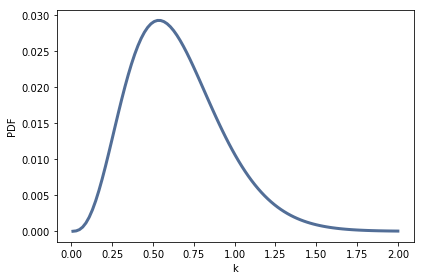

In [11]:
post_k = suite.Marginal(0)
print(post_k.Mean())
thinkplot.Pdf(post_k)
thinkplot.decorate(xlabel='k', ylabel='PDF')

And here's the posterior marginal for `theta`

2.4775986527658107


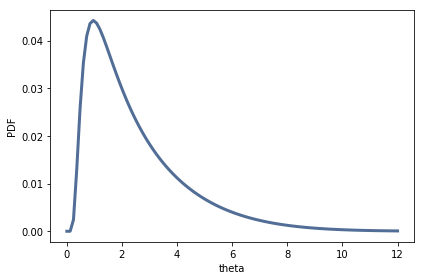

In [12]:
post_theta = suite.Marginal(1)
print(post_theta.Mean())
thinkplot.Pdf(post_theta)
thinkplot.decorate(xlabel='theta', ylabel='PDF')

To make the predictive distribution, we'll need to make PMF approximations to gamma distributions.

In [13]:
def make_gamma_pmf(xs, k, theta):
    ps = gamma_pdf(xs, k, theta)
    return Pmf(dict(zip(xs, ps)))

Here's a test case.

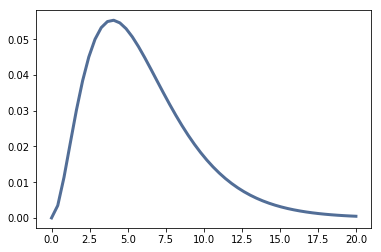

In [14]:
xs = np.linspace(0, 20)
pmf = make_gamma_pmf(xs, 3, 2)
thinkplot.Pdf(pmf)

Now we can make a mixture of gamma distributions with parameters from the posterior joint distribution.

In [27]:
xs = np.linspace(0.001, 30, 1001)

metapmf = Pmf()
for (k, theta), p in suite.Items():
    pmf = make_gamma_pmf(xs, k, theta)
    metapmf[pmf] = p

Here's the posterior predictive distribution.  Since it is so steep near 0, we need a pretty fine grid to get an accurate estimate of the posterior predictive mean (which we'll verify by comparison to the solution from MCMC below).

0.7356873128169283


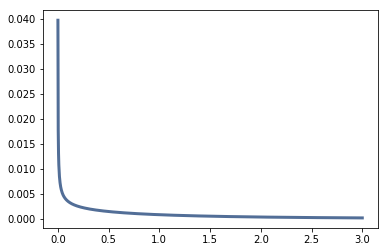

In [28]:
pred_pmf = MakeMixture(metapmf)
print(pred_pmf.Mean())
thinkplot.Pdf(pred_pmf)

### Now with PyMC

Although I generally like to do grid algorithms first and use them to validate the MCMC solution, this example almost works the other way.  I found it easier to write a demonstrably-correct solution in PyMC3, and I used it to help choose the grid location and resolution.

In [17]:
from warnings import simplefilter
simplefilter('ignore', FutureWarning)

import pymc3 as pm

Here's the model in three lines.  The only trick part is translating to yet another parameterization.

In [18]:
model = pm.Model()

with model:
    k = pm.HalfNormal('k', 0.5)
    theta = pm.HalfNormal('theta', 4)
    rain = pm.Gamma('rain', alpha=k, beta=1/theta, observed=data)

Sampling worked well enough with the default parameters.

In [19]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, k]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1496.17draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Here are the posterior distributions.

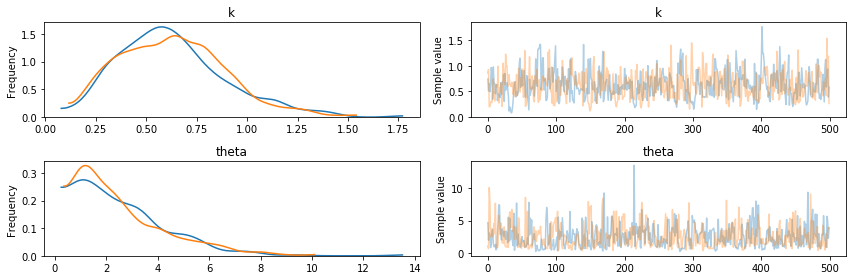

In [20]:
pm.traceplot(trace);

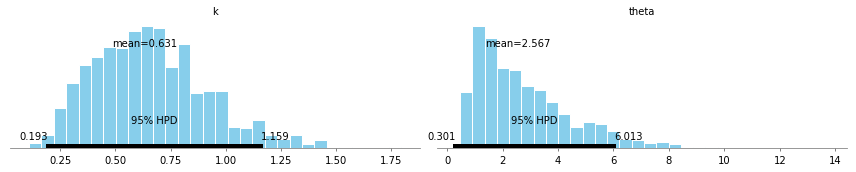

In [21]:
pm.plot_posterior(trace);

Here are the posterior means.

In [22]:
trace['k'].mean()

0.6306456636846653

In [23]:
trace['theta'].mean()

2.5673350235036154

### Predictions

Here's the posterior predictive distribution.

In [24]:
with model:
    pred = pm.sample_ppc(trace)

100%|██████████| 500/500 [00:00<00:00, 2055.85it/s]


And the posterior predictive mean.

In [25]:
pred['rain'].mean()

1.4396767923293652

Comparing the results from MCMC and the grid algorithm

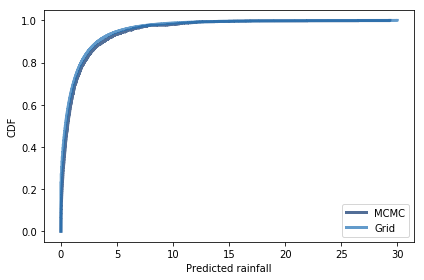

In [26]:
cdf = Cdf(pred['rain'].flatten())
thinkplot.Cdf(cdf, label='MCMC')
thinkplot.Cdf(pred_pmf.MakeCdf(), label='Grid')
thinkplot.decorate(xlabel='Predicted rainfall',
                   ylabel='CDF')

Looks good.  The predictive means are not quite the same; the most likely culprit is the resolution of the grid algorithm.